In [1]:
import os
import pandas as pd
import s3fs
import zipfile
from tqdm import tqdm
import torch
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import librosa
from scipy import signal
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torchaudio
import torch.optim as optim

In [2]:
DATASET_PATH = "../data/LivingRoom_preprocessed_hack"

In [3]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [22]:
centroids_h1 = np.load(DATASET_PATH + "/Human1/centroid.npy")
centroids_h2 = np.load(DATASET_PATH + "/Human2/centroid.npy")
deconvoled_trim_h1 = np.load(DATASET_PATH + "/Human1/deconvoled_trim.npy")
deconvoled_trim_h2 = np.load(DATASET_PATH + "/Human2/deconvoled_trim.npy")

In [55]:
print("Deconvoled Trim Human 1 Shape: ", deconvoled_trim_h1.shape)
print("Deconvoled Trim Human 2 Shape: ", deconvoled_trim_h2.shape)
print("Centroids Huma 1 Shape: ", centroids_h1.shape)
print("Centroids Human 2 Shape: ", centroids_h2.shape)
print(centroids_h1.shape)
print(centroids_h2.shape)
print(deconvoled_trim_h1)

Deconvoled Trim Human 1 Shape:  (1000, 4, 667200)
Deconvoled Trim Human 2 Shape:  (104, 4, 667200)
Centroids Huma 1 Shape:  (1000, 2)
Centroids Human 2 Shape:  (104, 2)
(1000, 2)
(104, 2)
[[[ 9.07240337e-06  1.71257434e-05  1.22597794e-05 ...  8.86178623e-06
    1.40686043e-05  1.06616626e-05]
  [-8.23853679e-06 -8.23373648e-06 -8.74563466e-06 ...  2.87394778e-06
   -8.90485808e-06 -3.52464713e-06]
  [ 6.62780906e-07 -1.40201587e-06  1.83228190e-06 ... -1.06218545e-06
    8.53497477e-06  2.28155182e-06]
  [ 8.11119719e-07 -2.47451499e-06  5.82140547e-06 ...  7.73804004e-06
    2.29692650e-05  1.10566034e-05]]

 [[ 1.64466037e-05  1.53698293e-05  1.91599720e-05 ...  1.76548729e-05
    1.70955263e-05  1.41169767e-05]
  [ 1.05826217e-07  9.13145777e-06  1.76140716e-07 ...  1.21369967e-05
    1.55958387e-05  1.23088676e-05]
  [ 7.06836090e-06  3.26818258e-06  7.15508941e-06 ...  4.64980394e-06
    8.96262554e-06  6.55734584e-06]
  [-3.18089551e-05 -8.93297238e-06 -2.51026504e-05 ... -7.027

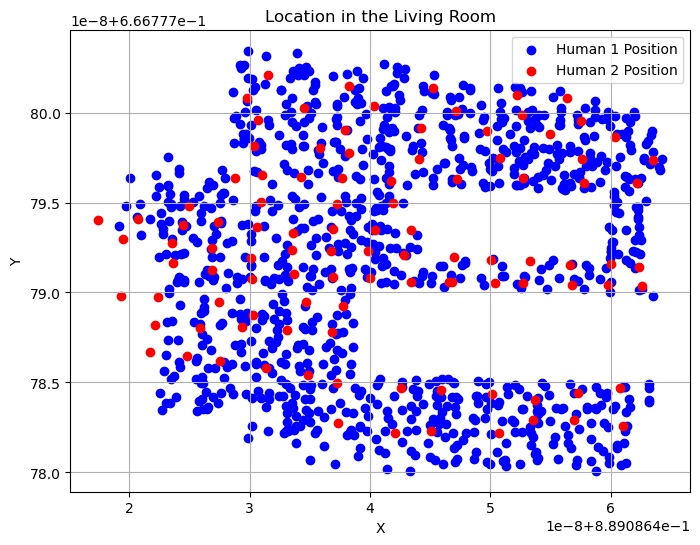

In [59]:
X_MIN = -4000
X_MAX = 500
Y_MIN = -4000
Y_MAX = 2000


def normalize_coordinates(centroids):
    room_width = X_MAX - X_MIN
    room_height = Y_MAX - Y_MIN

    centroids[:, 0] = (centroids[:, 0] - X_MIN) / room_width
    centroids[:, 1] = (centroids[:, 1] - Y_MIN) / room_height
    return centroids

norm_centroids_h1 = normalize_coordinates(centroids_h1)
norm_centroids_h2 = normalize_coordinates(centroids_h2)

df_norm_centroids_h1= pd.DataFrame(norm_centroids_h1, columns=['x', 'y'])
df_norm_centroids_h2= pd.DataFrame(norm_centroids_h2, columns=['x', 'y'])

plt.figure(figsize=(8, 6))

if 'y' in df_norm_centroids_h1.columns:
    plt.scatter(df_norm_centroids_h1['x'], df_norm_centroids_h1['y'], color='blue', label='Human 1 Position')

if 'y' in df_norm_centroids_h2.columns:
    plt.scatter(df_norm_centroids_h2['x'], df_norm_centroids_h2['y'], color='red', label='Human 2 Position')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Location in the Living Room')
plt.legend()
plt.grid(True)
plt.show()

# MICRO 1

In [24]:
# On s'occupe d'un seul Micro

deconvoled_trim_mic1_h1 = deconvoled_trim_h1[:, 0:1, :]

print(deconvoled_trim_mic1_h1.shape)
print(deconvoled_trim_mic1_h1)

(1000, 1, 667200)
[[[ 9.0724034e-06  1.7125743e-05  1.2259779e-05 ...  8.8617862e-06
    1.4068604e-05  1.0661663e-05]]

 [[ 1.6446604e-05  1.5369829e-05  1.9159972e-05 ...  1.7654873e-05
    1.7095526e-05  1.4116977e-05]]

 [[ 4.7109275e-05  4.4286378e-05  4.8188311e-05 ...  5.1171508e-05
    4.5416513e-05  4.6813693e-05]]

 ...

 [[-9.1993170e-06 -1.1256659e-05 -6.2540307e-06 ... -6.1832816e-06
   -7.3075289e-06 -5.6042400e-06]]

 [[-3.3129345e-06  8.9847827e-06  3.3953995e-06 ... -6.6372917e-07
   -1.8211606e-06 -4.2237971e-07]]

 [[-2.1806784e-06 -8.4515968e-06  6.2802104e-07 ... -7.2922603e-06
   -9.3879653e-06 -1.0631200e-05]]]


In [28]:
# a lancer la premiere fois et remettre en commentaire : !pip install torchaudio

import torch
import torchaudio.transforms as transforms

# Échantillonnage à 16 kHz
sample_rate = 16000

# Conversion de deconvoled_trim_mic1_h1 en un tenseur
data_tensor = torch.tensor(deconvoled_trim_mic1_h1)

# Normalisation des données
data_normalized = data_tensor / torch.max(torch.abs(data_tensor))

# Conversion en spectrogramme mél
mel_spectrogram_transform = transforms.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=2048,
    hop_length=512,
    n_mels=128,  # Nombre de filtres mél
)
mel_spectrograms = mel_spectrogram_transform(data_normalized)

# Prétraitement des spectrogrammes en transformant MFCC
mfcc_transform = transforms.MFCC(sample_rate=sample_rate, n_mfcc=13)
mfcc_features = mfcc_transform(mel_spectrograms)

print("Dimensions de l'entrée MFCC :", mfcc_features.shape)


/opt/mamba/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Dimensions de l'entrée MFCC : torch.Size([1000, 1, 128, 13, 7])


In [48]:
from VGGish.external.torchvggish.torchvggish.vggish import VGG, VGGish, make_layers
from VGGish.external.torchvggish.torchvggish.vggish_input import waveform_to_examples
from VGGish.external.torchvggish.torchvggish import mel_features
from VGGish.external.torchvggish.torchvggish import vggish_params
from VGGish import config


In [52]:
vggish_model_urls = {
    'vggish': 'https://github.com/harritaylor/torchvggish/'
              'releases/download/v0.1/vggish-10086976.pth',
    'pca': 'https://github.com/harritaylor/torchvggish/'
           'releases/download/v0.1/vggish_pca_params-970ea276.pth'
}

def vggish(pretrained=True, **kwargs):
    model = VGGish(urls=vggish_model_urls, pretrained_net=pretrained, postprocess=pretrained, **kwargs)
    return model

class VGGModel(torch.nn.Module):
        
    def __init__(self, fs=16000, pretrained=True):
        super(VGGModel, self).__init__()
        # self.vggish = torch.hub.load('harritaylor/torchvggish', 'vggish')
        self.vggish = vggish(pretrained=pretrained)
        self.vggish.eval()
        self.fs = fs
            
    def forward(self, x):
        x = (self.vggish.forward(torch.unsqueeze(x, axis=1), fs=self.fs) / 127) - 1
        # x = (self.vggish.forward(np.expand_dims(x, axis=1), fs=self.fs) / 127) - 1
        return x  

In [53]:
def get_finetune_model(pretrained=True, frozen=True, out_channels=2, dropout=False, in_channels=1):
    # Définir la variable pretrained ici
    pretrained = pretrained
    # TODO(sclarke): This pretrained model is based on 16kHz samples, and automatically downsamples input audio to 16k
    vggish_model = VGGModel(fs=config.PSEUDO_SAMPLE_RATE, pretrained=pretrained)
    if pretrained and frozen:
        for param in vggish_model.parameters():
            param.requires_grad = False
    p_dropout = 0.5 if dropout else 0.0
    finetune_model = torch.nn.Sequential(
        vggish_model,
        torch.nn.Linear(in_features=128, out_features=256, bias=True),
        torch.nn.ReLU(),
        torch.nn.Dropout(p_dropout),
        torch.nn.Linear(in_features=256, out_features=256, bias=True),
        torch.nn.ReLU(),
        torch.nn.Dropout(p_dropout),
        # torch.nn.Linear(in_features=256, out_features=256, bias=True),
        # torch.nn.ReLU(),
        torch.nn.Linear(in_features=256, out_features=out_channels, bias=True)
    ).cuda()
    
    return finetune_model

In [54]:
class CustomVGGish(VGG):
    def __init__(self, n_fft=256, hop_length=64, window_length=192, in_channels=None, out_channels=2, p_dropout=0.0, normalized=False, clip_value=None, device=None,):
        if not in_channels:
            #modified
            in_channels = 3 if normalized else 2 #2
            print('YO')
        super().__init__(make_layers(in_channels=in_channels, layer_desc=[64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, "M"]), cnn_height=4, cnn_width=4)
        if device is None:
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.device = device
        self.to(self.device)
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.window_length = window_length
        self.normalized = normalized
        self.clip_value = clip_value
        self.mlp = torch.nn.Sequential(
                            torch.nn.Linear(in_features=128, out_features=256, bias=True),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(p_dropout),
                            torch.nn.Linear(in_features=256, out_features=256, bias=True),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(p_dropout),
                            torch.nn.Linear(in_features=256, out_features=out_channels, bias=True)
                            ).cuda()

    def forward(self, x):
        x = self._preprocess(x)
        x = VGG.forward(self, x)
        x = self.mlp(x)
        return x

    def _preprocess(self, x):
    #The normalize flag will essentially determine if the preprocessing is like that in pretrained, or not.

        if isinstance(x, np.ndarray) or isinstance(x, torch.Tensor):
            reshape = False
            original_size = x.size()
            if x.dim() > 2:
                x = x.view(-1, x.size()[-1])
                reshape = True
            
            
            x = torch.stft( x,
                            n_fft=self.n_fft,
                            hop_length=self.hop_length,
                            win_length=self.window_length,
                            window=torch.hann_window(self.window_length).to(x.device),
                            return_complex=self.normalized
                            )

            #print("XSIZE")
            #print(x.size())

            if self.normalized:
                mag = torch.abs(x)
                if self.clip_value:
                    mag = torch.clamp(mag, max=self.clip_value) / self.clip_value
                angle = torch.angle(x)
                x = torch.stack((mag, torch.sin(angle), torch.cos(angle)), dim=1)
                #print("Normalized size before reshape")
                #print(x.size())
            else:
                x = torch.norm(x, dim=-1)
                x = torch.unsqueeze(x, dim=1)
                    

            if reshape:
                # print("orig siez")
                # print(original_size)
                # print("XSIZE")
                # print(x.size())
                # print(((original_size[0], original_size[1]*x.size()[1], x.size()[2], x.size()[3])))
                x = x.view(original_size[0], original_size[1]*x.size()[1], x.size()[2], x.size()[3])
                # print("XSIZE after view")
                # print(x.size())
                
        else:
            raise AttributeError
        return x

    def _postprocess(self, x):
        self.pproc.train(self.training)
        return self.pproc(x)